<a href="https://colab.research.google.com/github/gmrammohan15/EVA4/blob/master/S15-FinalAssignment-MaskDepth/S15Final_resnetDepthMask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd /content/gdrive/My\ Drive/DenseDepth_DataSet

/content/gdrive/My Drive/DenseDepth_DataSet


In [0]:
import argparse
import logging
import os
import sys

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import DataLoader, random_split

In [0]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.568, 0.512, 0.452],std = [0.211, 0.211, 0.216])
])
dataset = DenseDataSet(transform=train_transforms, scale=1)
batch_size = 64
val_percent = 0.1
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])


train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)


Creating dataset with 100 examples


In [0]:
import matplotlib.pyplot as plt


def plot_img_and_mask(img, mask):
    classes = mask.shape[2] if len(mask.shape) > 2 else 1
    fig, ax = plt.subplots(1, classes + 1)
    ax[0].set_title('Input image')
    ax[0].imshow(img)
    if classes > 1:
        for i in range(classes):
            ax[i+1].set_title(f'Output mask (class {i+1})')
            ax[i+1].imshow(mask[:, :, i])
    else:
        ax[1].set_title(f'Output mask')
        ax[1].imshow(mask)
    plt.xticks([]), plt.yticks([])
    plt.show()

images = next(iter(train_loader))
val_images = next(iter(val_loader))
fg_bg_image = images['fgbg_image']
bg_image = images['bg_image']
mask_image = images['mask']

#plot_img_and_mask(fg_bg_image, mask_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

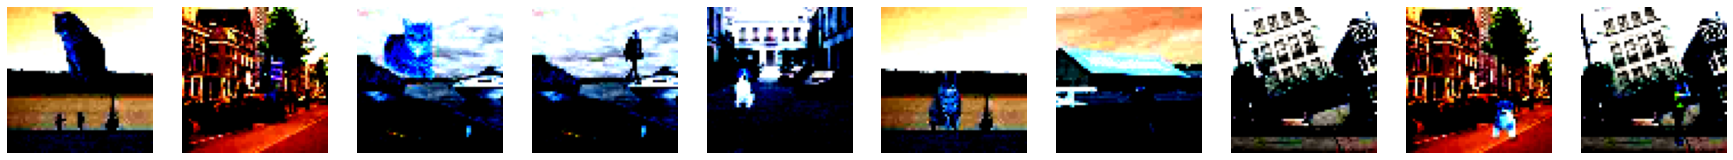

In [0]:
fg_bg_image.shape
fig = plt.figure(figsize=(200, 200))
num_imgs = fg_bg_image.shape[0]
for i in range(10):
    fig.add_subplot(1, num_imgs, i + 1)

    # render image tensor
    
    img = fg_bg_image[i]

    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))

    plt.imshow(npimg)
    plt.axis('off')

In [0]:
fg_bg_image.shape

torch.Size([128, 3, 96, 96])

In [0]:
mask_image.shape

torch.Size([128, 1, 96, 96])

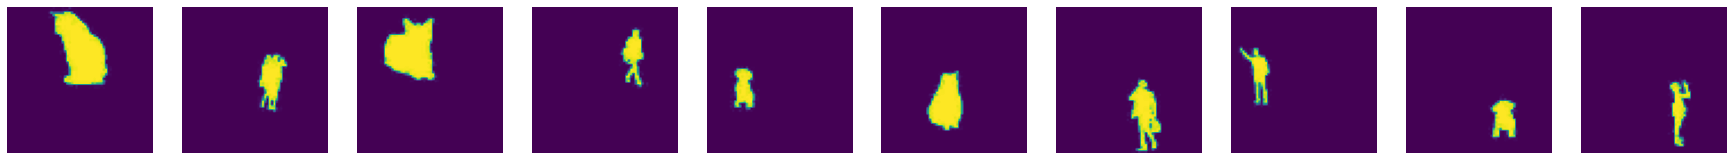

In [0]:

fig = plt.figure(figsize=(200, 200))
num_imgs = mask_image.shape[0]
for i in range(10):
    fig.add_subplot(1, num_imgs, i + 1)

    # render image tensor
    
    img = mask_image[i]
    mask = img[:, :, :]

    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))

    plt.imshow(npimg[:, :, 0])
    plt.axis('off')

In [0]:
!pip install tensorboardX==1.4

     |████████████████████████████████| 71kB 3.4MB/s 


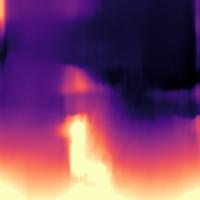

In [0]:
import torch as t
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()

# display tensor
a = t.Tensor(3, 64, 64).normal_()
to_img(a)

# display imagefile
Image('../dataset_training/fg_bg/bg_000/fg_004_bg_000_000009_disp.jpeg')

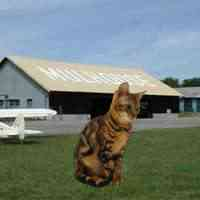

In [0]:
import torch as t
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()

# display tensor
a = t.Tensor(3, 64, 64).normal_()
to_img(a)

# display imagefile
Image('../dataset_training/fg_bg/bg_000/fg_004_bg_000_000009.jpg')

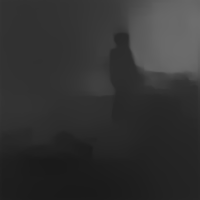

In [0]:
import torch as t
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()

# display tensor
a = t.Tensor(3, 64, 64).normal_()
to_img(a)

# display imagefile
Image('mask_fg_001_bg_000_000040.png')

In [0]:
from __future__ import absolute_import, division, print_function

import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
#from tensorboardX import SummaryWriter
#from torch.utils.tensorboard import SummaryWriter

import json

from utils import *
from kitti_utils import *
from layers import *

import datasets
import networks
from IPython import embed

In [0]:
from tensorboardX import SummaryWriter
lr = 1e-4
img_scale = 0.5

writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = {}
parameters_to_train = []
models["encoder"] = networks.ResnetEncoder(18, False)

models["encoder"].to(device)
parameters_to_train += list(models["encoder"].parameters())

scales = [0, 1, 2, 3]
frame_ids = [0, -1, 1]

models["mask"] = networks.DepthDecoder(models["encoder"].num_ch_enc, scales, num_output_channels=1)                           
models["mask"].to(device)
parameters_to_train += list(models["mask"].parameters())

model_parameters = filter(lambda p: p.requires_grad, models["mask"].parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

from torchsummary import summary
summary(models["encoder"], (3 , 128, 128))

3152724
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           

In [0]:
import torch.optim as optim
scheduler_step_size = 15
model_optimizer = optim.Adam(parameters_to_train, lr)
model_lr_scheduler = optim.lr_scheduler.StepLR(model_optimizer, scheduler_step_size, 0.1)
def set_train():
    """Convert all models to training mode
    """
    for m in models.values():
        m.train()

def set_eval():
    """Convert all models to testing/evaluation mode
    """
    for m in models.values():
        m.eval()


In [0]:
val_iter = iter(val_loader)
def val():
    """Validate the model on a single minibatch
    """
    set_eval()
    global val_iter
    try:
        inputs = val_iter.next()
    except StopIteration:
        val_iter = iter(val_loader)
        inputs = val_iter.next()

    with torch.no_grad():
        outputs, losses = process_batch(inputs)

        log(inputs, outputs, losses)
        del inputs, outputs, losses

    set_train()

In [0]:
def log_time(batch_idx, duration, loss, start_time, epoch):
    """Print a logging statement to the terminal
    """
    samples_per_sec = batch_size / duration
    time_sofar = time.time() - start_time

    print_string = "epoch {:>3} | batch {:>6} | examples/s: {:5.1f}" + \
        " | loss: {:.5f} | time elapsed: {} "
    print(print_string.format(epoch, batch_idx, samples_per_sec, loss,
                              sec_to_hm_str(time_sofar)))

def log(inputs, outputs, losses, step=0):
    """Write an event to the tensorboard events file
    """
    #writer = self.writers[mode]
    global writer
    for l, v in losses.items():
        writer.add_scalar("{}".format(l), v, step)

    writer.add_image("target_mask", inputs["mask"],  step)
    writer.add_image("predictive_mask", outputs["predictive_mask"]["disp", 0], step)   
    

def run_epoch(start_time, epoch):
    """Run a single epoch of training and validation
    """
    model_lr_scheduler.step()

    print("Training")
    set_train()
    global step
    print(step)
    log_frequency = 20
    for batch_idx, inputs in enumerate(train_loader):

        before_op_time = time.time()

        outputs, losses = process_batch(inputs)

        model_optimizer.zero_grad()
        losses["loss"].backward()
        model_optimizer.step()

        duration = time.time() - before_op_time

        early_phase = batch_idx % log_frequency == 0 and step < 2000
        late_phase = step % 2000 == 0

        if early_phase or late_phase:
            log_time(batch_idx, duration, losses["loss"].cpu().data, start_time, epoch)
            log(inputs, outputs, losses, step)
            val()

        step += 1
    return step

In [0]:
step = 0
def train():
    epoch = 0
    num_epochs = 100
    start_time = time.time()
    for epoch in range(num_epochs):
      run_epoch(start_time, epoch)

In [0]:
train()